In [1]:
import glob
import os
import pandas as pd
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
import sklearn.preprocessing as preproc
import sklearn.linear_model as lm
import sklearn.pipeline
from sklearn import decomposition
from scipy.optimize import least_squares
import geopandas as gpd
from requests import get,Session
import wget
from census import Census
from us import states
%matplotlib inline

In [2]:
# read in 2016 census tract shapefile (from https://www.census.gov/geo/maps-data/data/cbf/cbf_tracts.html)
gdf = gpd.read_file('/Users/nehrkorn/Downloads/cb_2016_06_tract_500k/cb_2016_06_tract_500k.shp')
gdf

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,06,013,359103,1400000US06013359103,06013359103,3591.03,CT,2593523,1170833,"POLYGON ((-122.302287 37.995278, -122.299658 3..."
1,06,013,366001,1400000US06013366001,06013366001,3660.01,CT,1017166,0,"POLYGON ((-122.353307 37.978544, -122.352953 3..."
2,06,013,374000,1400000US06013374000,06013374000,3740,CT,992095,0,"POLYGON ((-122.347509 37.939984, -122.347471 3..."
3,06,013,388000,1400000US06013388000,06013388000,3880,CT,659857,0,"POLYGON ((-122.308489 37.911273, -122.304275 3..."
4,06,017,030710,1400000US06017030710,06017030710,307.10,CT,7898800,0,"POLYGON ((-121.081663 38.692493, -121.079227 3..."
5,06,017,031402,1400000US06017031402,06017031402,314.02,CT,788931825,156657,"POLYGON ((-120.84683 38.558447, -120.845074 38..."
6,06,019,000300,1400000US06019000300,06019000300,3,CT,1887566,0,"POLYGON ((-119.813029 36.72862, -119.805003 36..."
7,06,019,000901,1400000US06019000901,06019000901,9.01,CT,1954608,0,"POLYGON ((-119.817891 36.714015, -119.808901 3..."
8,06,019,001408,1400000US06019001408,06019001408,14.08,CT,1218706,0,"POLYGON ((-119.7364 36.728666, -119.731949 36...."
9,06,019,002300,1400000US06019002300,06019002300,23,CT,1496251,0,"POLYGON ((-119.802846 36.754879, -119.80029 36..."


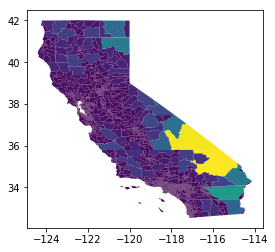

In [3]:
gdf.plot(column='ALAND')

In [4]:
# an example query with the census api wrapper
c = Census("fc40d0e5624aa1c5f10cb80e68c8a62d1d5bdc68")
c.acs5.get(('NAME', 'B25034_010E'),
          {'for': 'state:{}'.format(states.MD.fips)})

[{'B25034_010E': 133511.0, 'NAME': 'Maryland', 'state': '24'}]

In [5]:
# should return tract name and population for all tracts in CA
result = c.acs5.get('NAME,B01001_001E', geo={'for': 'tract:*',
                       'in': 'state:{}'.format(states.CA.fips)})

In [6]:
result

[{'B01001_001E': '3018',
  'NAME': 'Census Tract 4001, Alameda County, California',
  'county': '001',
  'state': '06',
  'tract': '400100'},
 {'B01001_001E': '1960',
  'NAME': 'Census Tract 4002, Alameda County, California',
  'county': '001',
  'state': '06',
  'tract': '400200'},
 {'B01001_001E': '5236',
  'NAME': 'Census Tract 4003, Alameda County, California',
  'county': '001',
  'state': '06',
  'tract': '400300'},
 {'B01001_001E': '4171',
  'NAME': 'Census Tract 4004, Alameda County, California',
  'county': '001',
  'state': '06',
  'tract': '400400'},
 {'B01001_001E': '3748',
  'NAME': 'Census Tract 4005, Alameda County, California',
  'county': '001',
  'state': '06',
  'tract': '400500'},
 {'B01001_001E': '1661',
  'NAME': 'Census Tract 4006, Alameda County, California',
  'county': '001',
  'state': '06',
  'tract': '400600'},
 {'B01001_001E': '4552',
  'NAME': 'Census Tract 4007, Alameda County, California',
  'county': '001',
  'state': '06',
  'tract': '400700'},
 {'B01

In [7]:
# make dataframe out of list of dicts
df = pd.DataFrame(result)
# add a tract code column that matches the shapefile (for merging)
df['GEOID'] = df.state+df.county+df.tract
df['B01001_001E'] = df['B01001_001E'].astype(int)
df

,B01001_001E,NAME,county,state,tract,GEOID
0,3018,"Census Tract 4001, Alameda County, California",001,06,400100,06001400100
1,1960,"Census Tract 4002, Alameda County, California",001,06,400200,06001400200
2,5236,"Census Tract 4003, Alameda County, California",001,06,400300,06001400300
3,4171,"Census Tract 4004, Alameda County, California",001,06,400400,06001400400
4,3748,"Census Tract 4005, Alameda County, California",001,06,400500,06001400500
5,1661,"Census Tract 4006, Alameda County, California",001,06,400600,06001400600
6,4552,"Census Tract 4007, Alameda County, California",001,06,400700,06001400700
7,3506,"Census Tract 4008, Alameda County, California",001,06,400800,06001400800
8,2262,"Census Tract 4009, Alameda County, California",001,06,400900,06001400900
9,6193,"Census Tract 4010, Alameda County, California",001,06,401000,06001401000


In [8]:
# merge (intersect, not union, for now)
gdf_merge = pd.merge(gdf,df[['B01001_001E','GEOID']],on='GEOID',how='inner')
gdf_merge

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,B01001_001E
0,06,013,359103,1400000US06013359103,06013359103,3591.03,CT,2593523,1170833,"POLYGON ((-122.302287 37.995278, -122.299658 3...",4907
1,06,013,366001,1400000US06013366001,06013366001,3660.01,CT,1017166,0,"POLYGON ((-122.353307 37.978544, -122.352953 3...",4470
2,06,013,374000,1400000US06013374000,06013374000,3740,CT,992095,0,"POLYGON ((-122.347509 37.939984, -122.347471 3...",4246
3,06,013,388000,1400000US06013388000,06013388000,3880,CT,659857,0,"POLYGON ((-122.308489 37.911273, -122.304275 3...",2776
4,06,017,030710,1400000US06017030710,06017030710,307.10,CT,7898800,0,"POLYGON ((-121.081663 38.692493, -121.079227 3...",4983
5,06,017,031402,1400000US06017031402,06017031402,314.02,CT,788931825,156657,"POLYGON ((-120.84683 38.558447, -120.845074 38...",5233
6,06,019,000300,1400000US06019000300,06019000300,3,CT,1887566,0,"POLYGON ((-119.813029 36.72862, -119.805003 36...",3270
7,06,019,000901,1400000US06019000901,06019000901,9.01,CT,1954608,0,"POLYGON ((-119.817891 36.714015, -119.808901 3...",2979
8,06,019,001408,1400000US06019001408,06019001408,14.08,CT,1218706,0,"POLYGON ((-119.7364 36.728666, -119.731949 36....",2522
9,06,019,002300,1400000US06019002300,06019002300,23,CT,1496251,0,"POLYGON ((-119.802846 36.754879, -119.80029 36...",3294


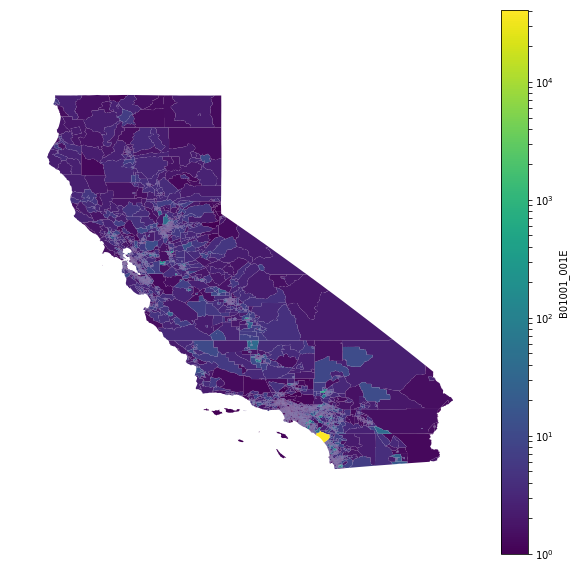

In [9]:
# plot the map
f, ax = plt.subplots(1, figsize=(10, 10))
norm = mpl.colors.LogNorm(vmin=gdf_merge['B01001_001E'].min()+1,vmax=gdf_merge['B01001_001E'].max())
h_plot = gdf_merge.plot(ax=ax, column='B01001_001E',cmap='viridis',vmin = gdf_merge['B01001_001E'].min()+1,vmax=gdf_merge['B01001_001E'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm._A = []
cbar = f.colorbar(sm)
cbar.ax.set_ylabel('B01001_001E')
ax.set_axis_off()
plt.axis('equal');

In [10]:
# check out the highest population tracts...
df.sort_values(by='B01001_001E')

,B01001_001E,NAME,county,state,tract,GEOID
3488,0,"Census Tract 9800.01, Los Angeles County, Cali...",037,06,980001,06037980001
3501,0,"Census Tract 9800.18, Los Angeles County, Cali...",037,06,980018,06037980018
6675,0,"Census Tract 9900, San Luis Obispo County, Cal...",079,06,990000,06079990000
3503,0,"Census Tract 9800.20, Los Angeles County, Cali...",037,06,980020,06037980020
3504,0,"Census Tract 9800.21, Los Angeles County, Cali...",037,06,980021,06037980021
3505,0,"Census Tract 9800.22, Los Angeles County, Cali...",037,06,980022,06037980022
7607,0,"Census Tract 9901, Sonoma County, California",097,06,990100,06097990100
3508,0,"Census Tract 9800.25, Los Angeles County, Cali...",037,06,980025,06037980025
3510,0,"Census Tract 9800.28, Los Angeles County, Cali...",037,06,980028,06037980028
3511,0,"Census Tract 9800.30, Los Angeles County, Cali...",037,06,980030,06037980030


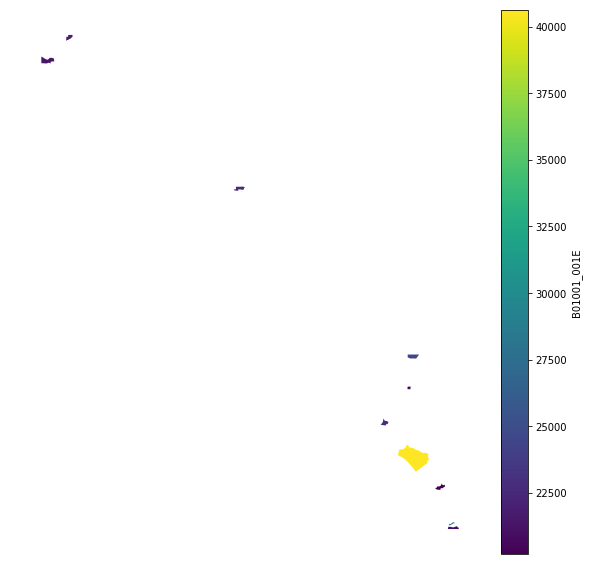

In [11]:
gdf_merge_top10 = gdf_merge.loc[gdf_merge.sort_values(by='B01001_001E').index[-10:],:]
f, ax = plt.subplots(1, figsize=(10, 10))
norm = mpl.colors.Normalize(vmin=gdf_merge_top10['B01001_001E'].min()+1,vmax=gdf_merge_top10['B01001_001E'].max())
h_plot = gdf_merge_top10.plot(ax=ax, column='B01001_001E',cmap='viridis',vmin = gdf_merge_top10['B01001_001E'].min()+1,vmax=gdf_merge_top10['B01001_001E'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm._A = []
cbar = f.colorbar(sm)
cbar.ax.set_ylabel('B01001_001E')
ax.set_axis_off()
plt.axis('equal');

In [12]:
# load in g16 sr precinct <--> census block crosswalk
df_g16_sr_to_blk = pd.read_csv('/Users/nehrkorn/Downloads/state_g16_sr_blk_map/state_g16_sr_blk_map.csv',
                               dtype={'FIPS':str,'TRACT':str,'SRPREC_KEY':str,'SRPREC':str})
df_g16_sr_to_blk

,ELECTION,TYPE,FIPS,SRPREC_KEY,SRPREC,BLOCK_KEY,TRACT,BLOCK,BLKREG,SRTOTREG,PCTSRPREC,BLKTOTREG,PCTBLK
0,g16,sr_blk,06001,06001200100,200100,60014211001000,421100,1000,8,760,1.052632,8,100.00000
1,g16,sr_blk,06001,06001200100,200100,60014211001001,421100,1001,66,760,8.684211,66,100.00000
2,g16,sr_blk,06001,06001200100,200100,60014211001002,421100,1002,48,760,6.315789,55,87.27272
3,g16,sr_blk,06001,06001200100,200100,60014211001003,421100,1003,20,760,2.631579,88,22.72727
4,g16,sr_blk,06001,06001200100,200100,60014211001007,421100,1007,50,760,6.578947,58,86.20689
5,g16,sr_blk,06001,06001200100,200100,60014211001008,421100,1008,40,760,5.263158,40,100.00000
6,g16,sr_blk,06001,06001200100,200100,60014211001009,421100,1009,94,760,12.368420,94,100.00000
7,g16,sr_blk,06001,06001200100,200100,60014211001010,421100,1010,113,760,14.868420,120,94.16666
8,g16,sr_blk,06001,06001200100,200100,60014211001011,421100,1011,104,760,13.684210,104,100.00000
9,g16,sr_blk,06001,06001200100,200100,60014211001012,421100,1012,3,760,0.394737,3,100.00000


In [13]:
# Pad the tract column with zeros
df_g16_sr_to_blk.TRACT = df_g16_sr_to_blk.TRACT.apply('{:0>6}'.format)
df_g16_sr_to_blk

,ELECTION,TYPE,FIPS,SRPREC_KEY,SRPREC,BLOCK_KEY,TRACT,BLOCK,BLKREG,SRTOTREG,PCTSRPREC,BLKTOTREG,PCTBLK
0,g16,sr_blk,06001,06001200100,200100,60014211001000,421100,1000,8,760,1.052632,8,100.00000
1,g16,sr_blk,06001,06001200100,200100,60014211001001,421100,1001,66,760,8.684211,66,100.00000
2,g16,sr_blk,06001,06001200100,200100,60014211001002,421100,1002,48,760,6.315789,55,87.27272
3,g16,sr_blk,06001,06001200100,200100,60014211001003,421100,1003,20,760,2.631579,88,22.72727
4,g16,sr_blk,06001,06001200100,200100,60014211001007,421100,1007,50,760,6.578947,58,86.20689
5,g16,sr_blk,06001,06001200100,200100,60014211001008,421100,1008,40,760,5.263158,40,100.00000
6,g16,sr_blk,06001,06001200100,200100,60014211001009,421100,1009,94,760,12.368420,94,100.00000
7,g16,sr_blk,06001,06001200100,200100,60014211001010,421100,1010,113,760,14.868420,120,94.16666
8,g16,sr_blk,06001,06001200100,200100,60014211001011,421100,1011,104,760,13.684210,104,100.00000
9,g16,sr_blk,06001,06001200100,200100,60014211001012,421100,1012,3,760,0.394737,3,100.00000


In [14]:
# load in g16 registration data for voters
df_g16_sor_vote = pd.read_csv('data/SWDB/state_g16_voters_by_g16_srprec/state_g16_voters_by_g16_srprec.csv',
                              dtype={'FIPS':str,'SRPREC_KEY':str,'SRPREC':str})
df_g16_sor_vote

,ELECTION,TYPE,FIPS,SRPREC_KEY,SRPREC,TOTREG_R,DEM,REP,AIP,PAF,...,IREG9G,OREG1G,OREG2G,OREG3G,OREG4G,OREG5G,OREG6G,OREG7G,OREG8G,OREG9G
0,g16,V,06001,06001200100,200100,650,488,29,4,0,...,21,10,2,1,1,2,0,1,0,4
1,g16,V,06001,06001200200,200200,626,472,30,8,4,...,17,5,2,4,2,1,0,0,1,7
2,g16,V,06001,06001200300,200300,496,363,21,1,2,...,10,6,0,1,1,1,0,0,1,2
3,g16,V,06001,06001200600,200600,574,431,18,7,1,...,10,7,2,1,2,2,0,1,1,7
4,g16,V,06001,06001200700,200700,576,428,16,4,0,...,15,10,1,1,0,2,0,2,0,3
5,g16,V,06001,06001200800,200800,551,406,27,4,0,...,25,5,1,0,2,0,0,1,1,8
6,g16,V,06001,06001201000,201000,554,415,30,3,1,...,15,7,2,0,2,0,1,1,3,0
7,g16,V,06001,06001201100,201100,580,442,13,6,0,...,22,4,2,1,1,1,0,3,0,2
8,g16,V,06001,06001201300,201300,556,428,10,3,1,...,11,6,1,2,0,3,0,1,0,2
9,g16,V,06001,06001201400,201400,593,454,20,4,0,...,19,6,0,1,1,1,0,1,1,1


In [15]:
# merge with crosswalk: should now have multiple rows for each sr precinct, one for each transecting block
df_swdb = pd.merge(df_g16_sor_vote,df_g16_sr_to_blk,on='SRPREC_KEY',how='inner')
df_swdb

,ELECTION_x,TYPE_x,FIPS_x,SRPREC_KEY,SRPREC_x,TOTREG_R,DEM,REP,AIP,PAF,...,FIPS_y,SRPREC_y,BLOCK_KEY,TRACT,BLOCK,BLKREG,SRTOTREG,PCTSRPREC,BLKTOTREG,PCTBLK
0,g16,V,06001,06001200100,200100,650,488,29,4,0,...,06001,200100,60014211001000,421100,1000,8,760,1.052632,8,100.00000
1,g16,V,06001,06001200100,200100,650,488,29,4,0,...,06001,200100,60014211001001,421100,1001,66,760,8.684211,66,100.00000
2,g16,V,06001,06001200100,200100,650,488,29,4,0,...,06001,200100,60014211001002,421100,1002,48,760,6.315789,55,87.27272
3,g16,V,06001,06001200100,200100,650,488,29,4,0,...,06001,200100,60014211001003,421100,1003,20,760,2.631579,88,22.72727
4,g16,V,06001,06001200100,200100,650,488,29,4,0,...,06001,200100,60014211001007,421100,1007,50,760,6.578947,58,86.20689
5,g16,V,06001,06001200100,200100,650,488,29,4,0,...,06001,200100,60014211001008,421100,1008,40,760,5.263158,40,100.00000
6,g16,V,06001,06001200100,200100,650,488,29,4,0,...,06001,200100,60014211001009,421100,1009,94,760,12.368420,94,100.00000
7,g16,V,06001,06001200100,200100,650,488,29,4,0,...,06001,200100,60014211001010,421100,1010,113,760,14.868420,120,94.16666
8,g16,V,06001,06001200100,200100,650,488,29,4,0,...,06001,200100,60014211001011,421100,1011,104,760,13.684210,104,100.00000
9,g16,V,06001,06001200100,200100,650,488,29,4,0,...,06001,200100,60014211001012,421100,1012,3,760,0.394737,3,100.00000


In [16]:
# make a column that's (for example) total number of registered voters from SR precinct in transecting block
# note: this should be close to BLKTOTREG
#       (different because we're looking at total registered voters that actually voted)
df_swdb['TOTREG_R_BLK'] = df_swdb['PCTSRPREC'] * df_swdb['TOTREG_R'] /100.
df_swdb

,ELECTION_x,TYPE_x,FIPS_x,SRPREC_KEY,SRPREC_x,TOTREG_R,DEM,REP,AIP,PAF,...,SRPREC_y,BLOCK_KEY,TRACT,BLOCK,BLKREG,SRTOTREG,PCTSRPREC,BLKTOTREG,PCTBLK,TOTREG_R_BLK
0,g16,V,06001,06001200100,200100,650,488,29,4,0,...,200100,60014211001000,421100,1000,8,760,1.052632,8,100.00000,6.842108
1,g16,V,06001,06001200100,200100,650,488,29,4,0,...,200100,60014211001001,421100,1001,66,760,8.684211,66,100.00000,56.447372
2,g16,V,06001,06001200100,200100,650,488,29,4,0,...,200100,60014211001002,421100,1002,48,760,6.315789,55,87.27272,41.052628
3,g16,V,06001,06001200100,200100,650,488,29,4,0,...,200100,60014211001003,421100,1003,20,760,2.631579,88,22.72727,17.105263
4,g16,V,06001,06001200100,200100,650,488,29,4,0,...,200100,60014211001007,421100,1007,50,760,6.578947,58,86.20689,42.763156
5,g16,V,06001,06001200100,200100,650,488,29,4,0,...,200100,60014211001008,421100,1008,40,760,5.263158,40,100.00000,34.210527
6,g16,V,06001,06001200100,200100,650,488,29,4,0,...,200100,60014211001009,421100,1009,94,760,12.368420,94,100.00000,80.394730
7,g16,V,06001,06001200100,200100,650,488,29,4,0,...,200100,60014211001010,421100,1010,113,760,14.868420,120,94.16666,96.644730
8,g16,V,06001,06001200100,200100,650,488,29,4,0,...,200100,60014211001011,421100,1011,104,760,13.684210,104,100.00000,88.947365
9,g16,V,06001,06001200100,200100,650,488,29,4,0,...,200100,60014211001012,421100,1012,3,760,0.394737,3,100.00000,2.565790


In [17]:
df_swdb['GEOID'] = df_swdb['FIPS_x'] + df_swdb['TRACT']
df_swdb

,ELECTION_x,TYPE_x,FIPS_x,SRPREC_KEY,SRPREC_x,TOTREG_R,DEM,REP,AIP,PAF,...,BLOCK_KEY,TRACT,BLOCK,BLKREG,SRTOTREG,PCTSRPREC,BLKTOTREG,PCTBLK,TOTREG_R_BLK,GEOID
0,g16,V,06001,06001200100,200100,650,488,29,4,0,...,60014211001000,421100,1000,8,760,1.052632,8,100.00000,6.842108,06001421100
1,g16,V,06001,06001200100,200100,650,488,29,4,0,...,60014211001001,421100,1001,66,760,8.684211,66,100.00000,56.447372,06001421100
2,g16,V,06001,06001200100,200100,650,488,29,4,0,...,60014211001002,421100,1002,48,760,6.315789,55,87.27272,41.052628,06001421100
3,g16,V,06001,06001200100,200100,650,488,29,4,0,...,60014211001003,421100,1003,20,760,2.631579,88,22.72727,17.105263,06001421100
4,g16,V,06001,06001200100,200100,650,488,29,4,0,...,60014211001007,421100,1007,50,760,6.578947,58,86.20689,42.763156,06001421100
5,g16,V,06001,06001200100,200100,650,488,29,4,0,...,60014211001008,421100,1008,40,760,5.263158,40,100.00000,34.210527,06001421100
6,g16,V,06001,06001200100,200100,650,488,29,4,0,...,60014211001009,421100,1009,94,760,12.368420,94,100.00000,80.394730,06001421100
7,g16,V,06001,06001200100,200100,650,488,29,4,0,...,60014211001010,421100,1010,113,760,14.868420,120,94.16666,96.644730,06001421100
8,g16,V,06001,06001200100,200100,650,488,29,4,0,...,60014211001011,421100,1011,104,760,13.684210,104,100.00000,88.947365,06001421100
9,g16,V,06001,06001200100,200100,650,488,29,4,0,...,60014211001012,421100,1012,3,760,0.394737,3,100.00000,2.565790,06001421100


In [18]:
reg_by_tract_swdb = df_swdb.groupby('GEOID')['TOTREG_R_BLK','BLKREG'].sum()

In [19]:
reg_by_tract_swdb.sort_values(by='TOTREG_R_BLK')

,TOTREG_R_BLK,BLKREG
GEOID,,
06053980000,0.609583,1
06037980022,0.701538,1
06037980006,0.752709,1
06037980007,0.788284,1
06037980003,1.000000,3
06029004601,1.000000,2
06037320000,1.000000,1
06037980002,1.166251,2
06037980025,1.240914,2


In [20]:
# check out the highest population tracts...
df.sort_values(by='B01001_001E')

,B01001_001E,NAME,county,state,tract,GEOID
3488,0,"Census Tract 9800.01, Los Angeles County, Cali...",037,06,980001,06037980001
3501,0,"Census Tract 9800.18, Los Angeles County, Cali...",037,06,980018,06037980018
6675,0,"Census Tract 9900, San Luis Obispo County, Cal...",079,06,990000,06079990000
3503,0,"Census Tract 9800.20, Los Angeles County, Cali...",037,06,980020,06037980020
3504,0,"Census Tract 9800.21, Los Angeles County, Cali...",037,06,980021,06037980021
3505,0,"Census Tract 9800.22, Los Angeles County, Cali...",037,06,980022,06037980022
7607,0,"Census Tract 9901, Sonoma County, California",097,06,990100,06097990100
3508,0,"Census Tract 9800.25, Los Angeles County, Cali...",037,06,980025,06037980025
3510,0,"Census Tract 9800.28, Los Angeles County, Cali...",037,06,980028,06037980028
3511,0,"Census Tract 9800.30, Los Angeles County, Cali...",037,06,980030,06037980030


In [21]:
# merge swdb and census
gdf_census_swdb = pd.merge(gdf_merge,reg_by_tract_swdb,left_on='GEOID',right_index=True,how='inner')
gdf_census_swdb

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,B01001_001E,TOTREG_R_BLK,BLKREG
0,06,013,359103,1400000US06013359103,06013359103,3591.03,CT,2593523,1170833,"POLYGON ((-122.302287 37.995278, -122.299658 3...",4907,2138.289089,2803
1,06,013,366001,1400000US06013366001,06013366001,3660.01,CT,1017166,0,"POLYGON ((-122.353307 37.978544, -122.352953 3...",4470,1249.852913,1976
2,06,013,374000,1400000US06013374000,06013374000,3740,CT,992095,0,"POLYGON ((-122.347509 37.939984, -122.347471 3...",4246,1541.155797,2215
3,06,013,388000,1400000US06013388000,06013388000,3880,CT,659857,0,"POLYGON ((-122.308489 37.911273, -122.304275 3...",2776,1393.303455,1666
4,06,017,030710,1400000US06017030710,06017030710,307.10,CT,7898800,0,"POLYGON ((-121.081663 38.692493, -121.079227 3...",4983,2931.569284,3405
5,06,017,031402,1400000US06017031402,06017031402,314.02,CT,788931825,156657,"POLYGON ((-120.84683 38.558447, -120.845074 38...",5233,3213.948502,3888
6,06,019,000300,1400000US06019000300,06019000300,3,CT,1887566,0,"POLYGON ((-119.813029 36.72862, -119.805003 36...",3270,769.110559,1675
7,06,019,000901,1400000US06019000901,06019000901,9.01,CT,1954608,0,"POLYGON ((-119.817891 36.714015, -119.808901 3...",2979,442.909202,975
8,06,019,001408,1400000US06019001408,06019001408,14.08,CT,1218706,0,"POLYGON ((-119.7364 36.728666, -119.731949 36....",2522,782.999992,1168
9,06,019,002300,1400000US06019002300,06019002300,23,CT,1496251,0,"POLYGON ((-119.802846 36.754879, -119.80029 36...",3294,981.664674,1861


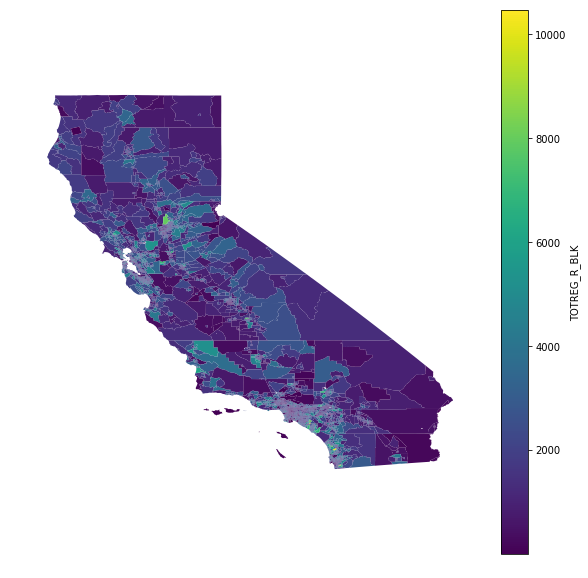

In [22]:
# plot the map
f, ax = plt.subplots(1, figsize=(10, 10))
norm = mpl.colors.Normalize(vmin=gdf_census_swdb['TOTREG_R_BLK'].min()+1,vmax=gdf_census_swdb['TOTREG_R_BLK'].max())
h_plot = gdf_census_swdb.plot(ax=ax, column='TOTREG_R_BLK',cmap='viridis',vmin = gdf_census_swdb['TOTREG_R_BLK'].min()+1,vmax=gdf_census_swdb['TOTREG_R_BLK'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm._A = []
cbar = f.colorbar(sm)
cbar.ax.set_ylabel('TOTREG_R_BLK')
ax.set_axis_off()
plt.axis('equal');

In [1]:
gdf_census_swdb.crs

NameError: name 'gdf_census_swdb' is not defined

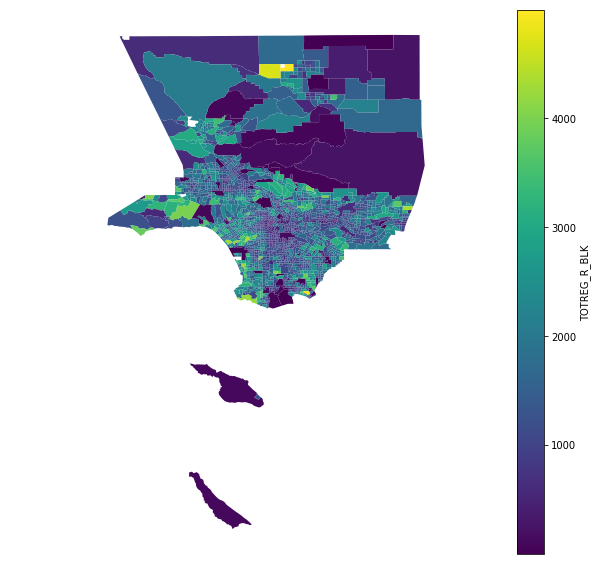

In [23]:
gdf_census_swdb_LA = gdf_census_swdb.query('COUNTYFP == "037"')
# plot the map
f, ax = plt.subplots(1, figsize=(10, 10))
norm = mpl.colors.Normalize(vmin=gdf_census_swdb_LA['TOTREG_R_BLK'].min()+1,vmax=gdf_census_swdb_LA['TOTREG_R_BLK'].max())
h_plot = gdf_census_swdb_LA.plot(ax=ax, column='TOTREG_R_BLK',cmap='viridis',vmin = gdf_census_swdb_LA['TOTREG_R_BLK'].min()+1,vmax=gdf_census_swdb_LA['TOTREG_R_BLK'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm._A = []
cbar = f.colorbar(sm)
cbar.ax.set_ylabel('TOTREG_R_BLK')
ax.set_axis_off()
plt.axis('equal');

In [24]:
# voter turnout (out of entire pop-- not a good stat, but just a sanity check)
gdf_census_swdb['TURNOUT'] = gdf_census_swdb['TOTREG_R_BLK'] / (gdf_census_swdb['B01001_001E'])
gdf_census_swdb.loc[gdf_census_swdb['TURNOUT']==np.inf,'TURNOUT']=np.nan
gdf_census_swdb.query('TURNOUT > 1') # we didn't pass the sanity check for every tract...

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,B01001_001E,TOTREG_R_BLK,BLKREG,TURNOUT
1930,06,037,575500,1400000US06037575500,06037575500,5755,CT,1316269,59886,"POLYGON ((-118.227512 33.790368, -118.226117 3...",43,80.259172,434,1.866492
2813,06,075,980900,1400000US06075980900,06075980900,9809,CT,3585241,260702,"POLYGON ((-122.406952 37.740495, -122.40459 37...",260,323.606423,423,1.244640
2877,06,059,021813,1400000US06059021813,06059021813,218.13,CT,4073721,622433,"POLYGON ((-117.837383 33.853058, -117.837618 3...",102,560.758725,719,5.497635
2912,06,059,052404,1400000US06059052404,06059052404,524.04,CT,23563124,0,"POLYGON ((-117.75361 33.674323, -117.752955 33...",895,2002.000000,2630,2.236872
2938,06,083,980000,1400000US06083980000,06083980000,9800,CT,4472363,234871,"POLYGON ((-119.859588 34.430556, -119.849281 3...",8,8.206428,10,1.025803
4130,06,083,002915,1400000US06083002915,06083002915,29.15,CT,1326504,110396,"POLYGON ((-119.884917 34.421684, -119.88493 34...",525,872.029624,1015,1.661009
4139,06,075,022600,1400000US06075022600,06075022600,226,CT,1357820,503898,"POLYGON ((-122.393968 37.766614, -122.388164 3...",2082,2808.093381,3263,1.348748
4695,06,059,980000,1400000US06059980000,06059980000,9800,CT,2766486,0,"POLYGON ((-117.928429 33.818033, -117.917866 3...",25,114.616565,202,4.584663
6516,06,001,982000,1400000US06001982000,06001982000,9820,CT,1269350,269265,"POLYGON ((-122.313212 37.795303, -122.307743 3...",58,102.257226,167,1.763056
6666,06,037,532400,1400000US06037532400,06037532400,5324,CT,12496795,442625,"POLYGON ((-118.239708 34.014713, -118.222712 3...",88,138.858261,202,1.577935


In [25]:
gdf_census_swdb.loc[gdf_census_swdb['TURNOUT']>1,'TURNOUT']=np.nan

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


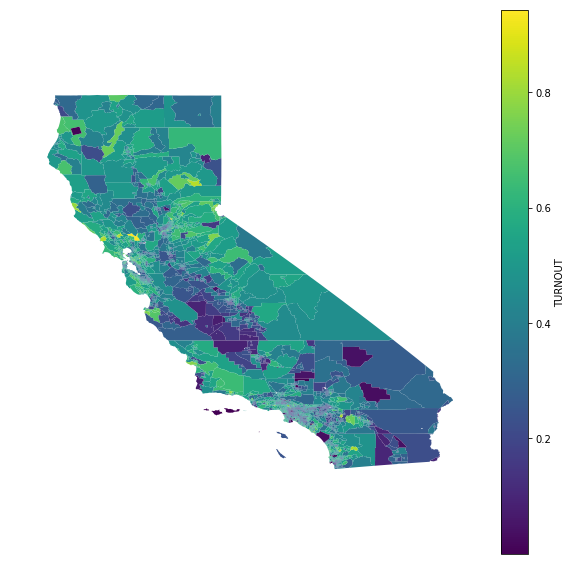

In [26]:
# plot the map
f, ax = plt.subplots(1, figsize=(10, 10))
norm = mpl.colors.Normalize(vmin=gdf_census_swdb['TURNOUT'].min(),vmax=gdf_census_swdb['TURNOUT'].max())
h_plot = gdf_census_swdb.plot(ax=ax, column='TURNOUT',cmap='viridis',vmin = gdf_census_swdb['TURNOUT'].min(),vmax=gdf_census_swdb['TURNOUT'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm._A = []
cbar = f.colorbar(sm)
cbar.ax.set_ylabel('TURNOUT')
ax.set_axis_off()
plt.axis('equal');

In [27]:
import folium
m = folium.Map([37.166111, -119.449444], zoom_start=4)

#geo_data = folium.GeoJson(gdf_census_swdb)

m.choropleth(geo_data = gdf_census_swdb.to_json(), data = gdf_census_swdb,
             columns = ['GEOID','TURNOUT'], key_on = 'feature.properties.GEOID',
             fill_color='YlGn',
             highlight=True)

m.save('test.html')